# Multimodality & Different Samplers

- Though HMC is a particularly good sampler in most cases and has very good dimensionality scaling, it is a poor fit to multimodal distributions
- In this document, demonstrate the concerns that HMC runs into in even simple multimodal distributions, and use this as a lense to examine a few other features of NumPyro, including a few of its samplers

In [1]:
import jax, numpyro, jaxopt
import jax.numpy as jnp
from numpyro import infer, distributions

import numpy as np
from chainconsumer import ChainConsumer
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/home/hughmc/anaconda3/envs/nestconda_latest/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, we'll generate a simple multimodal distribution.
* Four simple 'islands' of gaussian probability
* One of them of a lower prevalence / height
* Can easily assemble this arbitrary posterior shape using `numpyro.factor`

In [26]:
width, spacing = 0.25, 3.0 # Width / dist from center of gaussian modes

# Prior Volume
xmin, xmax = -10, 10
ymin, ymax = -10,10

#----------------------------

def potential(x,y):
    '''Multimodal potential function'''
    out=0
    
    # Likelihood Modes
    out+=jnp.exp(-1/2* (jnp.power((x - spacing),2) + jnp.power(y,2)) / width**2) * 0.5 # Mode on right, half as high
    out+=jnp.exp(-1/2* (jnp.power((x + spacing),2) + jnp.power(y,2))/ width**2)   # left mode
    out+=jnp.exp(-1/2* (jnp.power(x, 2)   + jnp.power(y-spacing,2))/ width**2) # top mode 
    out+=jnp.exp(-1/2* (jnp.power(x, 2)   + jnp.power(y+spacing,2))/ width**2) # bottom mode
    
    return(out)
     
def model():
    '''NumPyro Model'''
    x = numpyro.sample('x', numpyro.distributions.Uniform(xmin,xmax))
    y = numpyro.sample('y', numpyro.distributions.Uniform(ymin,ymax))

    # Extra 1E-15 term required because samplers can break when the potential gets too close to zero
    numpyro.factor('potfunc',jnp.log(potential(x,y) + 1E-15) ) 

Conside the simple multi-modal distribution defined above. It has 4 fully separated gaussian peaks in a cross pattern, with  the one on the right half the height / peak likelihood of the others. A good MCMC run should find all of these peaks and their heights:

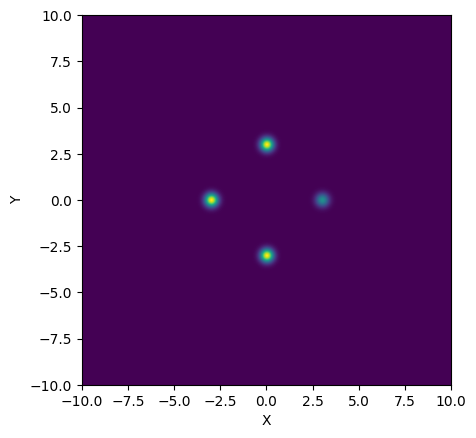

In [93]:
# Generate a grid of X/Y values
nplot = 1024
xplot, yplot = jnp.linspace(xmin,xmax, nplot), jnp.linspace(ymin,ymax, nplot)
X, Y = jnp.meshgrid(xplot, yplot)

# Use these to construct the potential function
Z = potential(X,Y)
plt.imshow(Z[::-1,::], extent = [xmin, xmax, ymin, ymax]) # Plot heatmap of the distribution
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Testing Different Samplers
- Here, test different samplers available in NumPyro to see how they perform against this multimodal distribution

Every chain needs to end at an island. If there are $n_{modes}$ modes, then the chance of landing in any one island is $p=1/n_{modes}$. From this, we can estimate how many chains end up in each mode. For $N$ total chains:

\begin{equation}
N_{i}=pN \pm \sqrt{Np(1-p)} \\
\frac{N_{i}}{N} = p \pm \frac{1}{\sqrt{N}} \frac{\sqrt{(p (1-p)}}{p}
\end{equation}

If we have $n_{modes}=4$, i.e. $p=\frac{1}{m}$, and want to measure this smallest mode accurately to within  $\Delta \frac{N_{i}}{N} < 10 \%$, we need $\approx300$ chains. The number of burn-in steps has been tuned with trial and error to a minimum value of $n_{burn}\approx 200$.

### Hamiltonian Monte-Carlo (HMC) / The No U-Turn Sampler (NUTS)

- The go-to workhorse of NumPyro, an efficient sampler with good high-dimensional scaling. NumPyro works by "rolling a ball" around a landscape with potential wells at high likelihood, randomizing the direction and kinetic energy of the ball at random intervals
- Makes it great at in high dimensions and for complicated posteriors
- Works poorly when there are multiple modes, as each individual chain can't transit between them and becomes pinned at local optima
- Closest thing to a valid approach is to just throw many (hundreds) of chains at the board and hope they map the modes properly. We'll see in a moment that even this is not a proper solution

**How it Works**
- a

In [84]:
nchains  = 300
nsamples = 100
nburn    = 200

sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(model),
    num_warmup  = nburn,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)

print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output_HMC=sampler.get_samples()



Starting Sampling...
Sampling Done


Though NUTS does a good job (after burn-in) of locating each of the modes, it <i>doesn't</i> succesfully identify their heights. Because the modes are so fully separated, chains stick to whichever mode they first encounter, and so each mode is equally occupied / has roughly the same height:

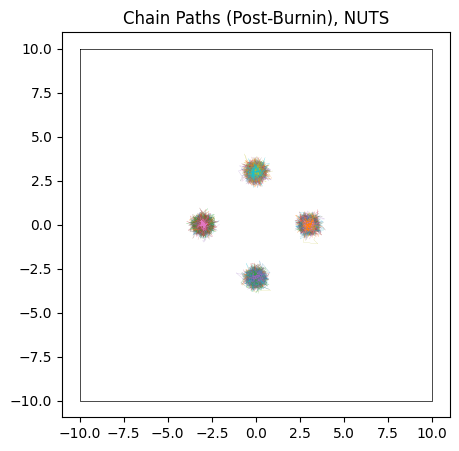

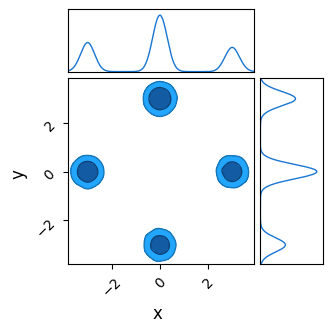

In [41]:
c = ChainConsumer()
def do_plot(results, name, do_paths = True, do_contour = True):

    #--------------------
    if do_paths:
        plt.figure(figsize=(5,5))
        
        plt.title("Chain Paths (Post-Burnin), %s" %name)
        plt.axis('equal')
        
        plt.plot([xmin,xmax,xmax,xmin,xmin], [ymax,ymax,ymin,ymin,ymax],c='k',lw=0.5)
        plt.errorbar( [-spacing,0,0,spacing], [0,-spacing,spacing,0], xerr=width, yerr=width,c='r',fmt='none')
        
        #Plot Chains
        for i in range(nchains):
            plt.plot(results['x'][i*nsamples:(i+1)*nsamples], results['y'][i*nsamples:(i+1)*nsamples], lw=0.1)
        plt.show()
        
    #--------------------
    # Chain Consumer plot
    if do_contour:
        if name in [chain.name for chain in c.chains]: c.remove_chain(name)
        c.add_chain([results['x'], results['y']], parameters=['x','y'], name=name, shade_alpha = 1.0)
        c.plotter.plot(chains=[name])
    
        plt.show()

#============================
do_plot(output_HMC, "NUTS")

**Pros & cons**  
Short introduction

<ins>The Good</ins>
- _Very_ good scaling with dimension: the best of any current method
- Converges _fast_, burn-in is super efficient as the use of gradients lets the walker rapidly track towards modes 
- Automatic tuning makes it a (mostly) reliable "out of the box" tool for complicated posteriors without manual tuning
- Uses internal coordinate transformations to handle correlated contours (see discussion of the [mass matrix](https://mc-stan.org/docs/2_19/reference-manual/hmc-algorithm-parameters.html) in HMC)
- Can handle unusual shapes and curved contours without distorting your results

<ins>The Bad</ins>
- JAX makes evaluating gradients _cheaper_, but not free. The cost of each evaluation in HMC will always be higher than a non-gradient method
- Uses multiple evaluations per sample, and it's not always obvious how many. In bad cases, sampling can slow to a crawl so the integrator can handle complicated geometry
- Can get expensive for complex geometry as the step size is reduced and the automatic tuning becomes difficult.
- Cannot handle multimodal distributions at all, as chains can't migrate between modes
- Has trouble navigating in "rough" geometry, e.g. sharp walls of low potential (like we often see in aliasing problems)

### Barker Metropolis-Hastings
- Another grad-based approach with good performance
- Works by using a normal metropolis hastings-type proposal, but uses the gradient to skew the distribution such that it is weighted to travel "uphill"
- Doesn't scale as well as HMC (efficacy decays with $d^{-\frac{1}{3}}$ rather than HMC's $d^{-\frac{1}{4}}$), but the more stochastic nature makes it better at escaping small local optima

**How it Works**  
- a
- a
- a

In [8]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.BarkerMH (model),
    num_warmup  = 400,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)
print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output_BMH =sampler.get_samples()

Starting Sampling...
Sampling Done


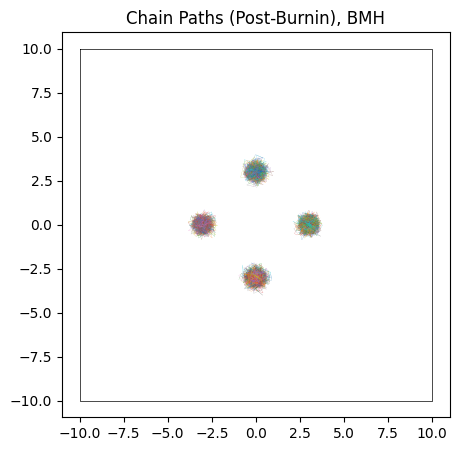

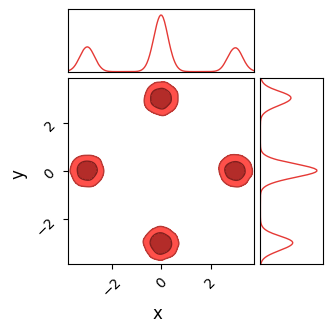

In [9]:
do_plot(output_BMH, "BMH")

**Pros & cons**  
- Good dimensionality scaling
- One eval for every sample: easier to determine run-time a-priori
- Stochastic "jumping" allows it to jump small gaps between modes
- Good dimensionality scaling: goes like $d^{1/3}$
- Uses internal coordinate transformations (see discussion of the [mass matrix](https://mc-stan.org/docs/2_19/reference-manual/hmc-algorithm-parameters.html) in HMC) to handle correlated datasets
- <span style="color:red">Requires evaluating gradients, which can get expensive</span>
- <span style="color:red">Warm-up can involve tuning a mass matrix, which can get expensive for non-linear correlations</span>
- <span style="color:red">Dimensionality scaling not _quite_ as good as HMC</span>
- <span style="color:red">Fails in multi-modal distributions: can't jump between samples</span>


**Pros & cons**  
Short introduction

<ins>The Good</ins>
- _Very_ good scaling with dimension: the best of any current method
- Converges _fast_, burn-in is super efficient as the use of gradients lets the walker rapidly track towards modes 
- Automatic tuning makes it a (mostly) reliable "out of the box" tool for complicated posteriors without manual tuning
- Uses internal coordinate transformations to handle correlated contours (see discussion of the [mass matrix](https://mc-stan.org/docs/2_19/reference-manual/hmc-algorithm-parameters.html) in HMC)
- Can handle unusual shapes and curved contours without distorting your results

<ins>The Bad</ins>
- Uses multiple steps per sample, and it's not always obvious how deep this goes. In bad cases, sampling can slow to a crawl as the integrator slows down to handle complicated geometry
- Can get expensive for complex geometry as the step size is reduced and the automatic tuning becomes difficult.
- Cannot handle multimodal distributions at all, as chains can't migrate between modes
- Has trouble navigating in "rough" geometry, e.g. sharp walls of low potential (like we often see in aliasing problems)

### Sample Adaptive Sampler

- Less complicated
- Cheaper individual itterations
- Much less efficient, poor scaling

**How it Works**  
The [Sample-Adaptive Sampler](https://proceedings.neurips.cc/paper_files/paper/2019/file/2cfa8f9e50e0f510ede9d12338a5f564-Paper.pdf) operates by tracking an ensemble of points in parameter space and approximating them as following a gaussian bubble. In this way, it's similar to the classic metropolis hastings algorithm, but wih a self-tuning proposal distribution.  

The procedure at each step is to, at each itteration:
- Define a multivariate gaussian, $g(\theta)$, based on the mean and covaraince of the current ensemble of $N$ samples
- Draw a new sample from this distribution and calculate its likelihood, $\mathcal{L}(\theta_{N+1})$
- For each sample $\theta_{i}$ in the ensemble (including the new point, $i \in [1,N+1]$):
  - Replace that sample $\theta_{i}$ with the new proposal sample $\theta_{N+1}$
    - Re-calculate a multivariate gaussian based on the mean and covariance of this ensemble, $g_{i}(\theta)$
    - Calculate $\lambda_i = g_{i}(\theta_i) / \mathcal{L}(\theta_i)$
- Randomly select one of these sub-ensembles to proceed with, using probability proportional to $\lambda_i$ 

In [6]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.SA(model),
    num_warmup  = 4000,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)
print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output_SA=sampler.get_samples()

Starting Sampling...
Sampling Done


Unlike NUTS, in which each chain sticks to the first mode it finds, SA's less sophisticated pathfinding lets is hop between islands. For the same number of chains and samples, SA does a better job of recovering the true distribution, but at the cost of being much less efficient.

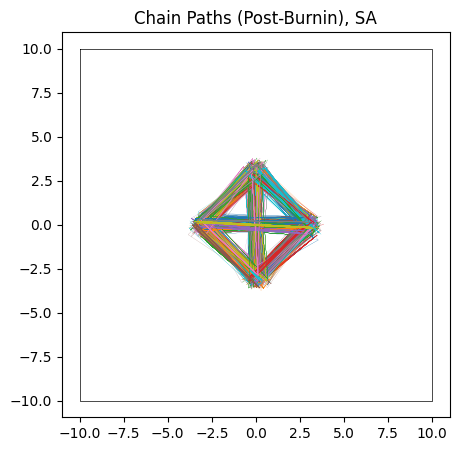

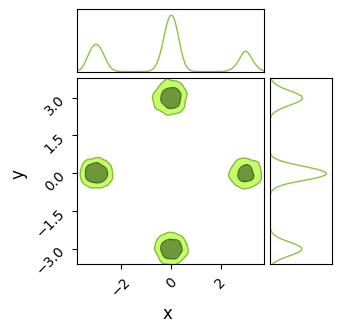

In [7]:
do_plot(output_SA, "SA")

### Nested Sampling

- None of NumPyro's native MCMC samplers work particularly well in multimodal distributions
- Though they can locate the modes decently well, they fail to adequatly identify their prevalence
- Fortunately, we have another tool at our disposal that is purpose built for multimodal distributions: Nested Sampling
- Technically not an MCMC method, and so tends to produce "rougher" contours for the same number of samples, but its results can be weighted 
- I have a more detailed writeup of the interface / mechanisms of NS in NumPyro over [here](#), but the central idea is this:
- Generate a set of $N$ "Live Points", distributed evenly across the prior
- Remove the first point and log it as a sample
- Find another point drawn uniformly from the region of parameter space at higher likelihood than this dead point
- Repeat the last two steps until the ensemble has converged to a small volume

The idea here is that removing the $N^{th}$ point in your "Live Points" will shrink the volume subtended by your ensembled by a factor of $\approx 1-1/N$. E.g. if we have $100$ live points and remove the worst one, the volume should contract by about $1 \%$. Because we know the likelihood of each dead point and have this estimate of the volume at at similar likelihoods, we can re-weight our chain of dead points to get an MCMC-like output. 

As NS isn't an MCMC method, we can't perfectly map tuning parameters like "burn-in" or "number of chains" onto it. Instead, for the sake of fairness, we can set it to have the same number of _total_ samples across the entire run.

In [74]:
from numpyro.contrib.nested_sampling import NestedSampler

nlive = nchains*(nsamples+nburn) // 4 // 42
NS = NestedSampler(model, constructor_kwargs={"num_live_points" : nlive, "max_samples": nlive*4})
print("Starting Sampling")
NS.run(jax.random.PRNGKey(1))
print("Sampling Done")

Starting Sampling
Sampling Done


In [80]:
dir(sampler)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_args',
 '_cache',
 '_collection_params',
 '_compile',
 '_default_fields',
 '_get_cached_fns',
 '_get_cached_init_state',
 '_init_state_cache',
 '_jit_model_args',
 '_kwargs',
 '_last_state',
 '_sample_field',
 '_set_collection_params',
 '_single_chain_mcmc',
 '_states',
 '_states_flat',
 '_warmup_state',
 'chain_method',
 'get_extra_fields',
 'get_samples',
 'last_state',
 'num_chains',
 'num_samples',
 'num_warmup',
 'post_warmup_state',
 'postprocess_fn',
 'print_summary',
 'progress_bar',
 'run',
 'sampler',
 'thinning',
 'warmup']

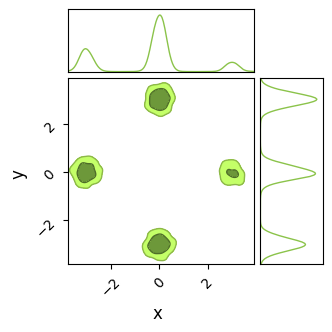

In [75]:
output_NS = NS.get_samples(jax.random.PRNGKey(1), num_samples = nsamples*nchains)
do_plot(output_NS, name = "NS", do_paths=False)

# When Flat-space Isn't Flat

In the previous example, we considered only the simple case of a 'smooth' posterior. Under these cases, HMC returns results that are a bit skewed, but not entirely unreasonable. However, HMC can fail entirely if the inter-modal 'flat' space isn't flat. Its leveraging of gradients makes it extremely susceptible to getting pinned against any features of 'roughness' in the likelihood function

Like before, we'll create a potential function and send it to NumPyro, but this time adding a semi-regular 'noise'

In [12]:
%%script echo "Dont run"
def bad_potential(x,y):
    return potential(x,y) + (jnp.exp(jnp.sin(10*x)/2) * jnp.exp(jnp.sin(10*y)/8) -0.5) * 0.001

def bad_model():
    x = numpyro.sample('x', numpyro.distributions.Uniform(xmin,xmax))
    y = numpyro.sample('y', numpyro.distributions.Uniform(ymin,ymax))
    
    numpyro.factor('potfunc',jnp.log(bad_potential(x,y) + 1E-14))

Dont run


This 'noise' is very low contrast, the peaks and valleys it forms are not even visible when looking at the marginalized likelihood, but are still very much present.

In [13]:
%%script echo "Dont run"
nplot = 1024
Z2 = bad_potential(X,Y)

fig_grid, ax_grid = plt.subplots(1,2, figsize=(8,4))

ax_grid[0].imshow(np.log(Z2[::-1,::]), extent = [xmin, xmax, ymin, ymax])
ax_grid[1].imshow(Z2[::-1,::], extent = [xmin, xmax, ymin, ymax])
ax_grid[0].set_title("Likelihood")
ax_grid[1].set_title("Log Likelihood")

fig_grid.tight_layout()

#---------------------

fig, ax=plt.subplots(2,1,figsize=(4,4))

ax[0].plot( xplot, np.sum(Z,axis=1))
ax[1].plot( yplot, np.sum(Z,axis=0))
ax[0].set_xlim([-4,4])
ax[1].set_xlim([-4,4])
ax[0].set_title("Marginalized X Distribution")
ax[1].set_title("Marginalized Y Distribution")

fig.tight_layout()
plt.show()

Dont run


Now, try running HMC on this distribution:

In [14]:
%%script echo "Dont run"
nchains  = 3
nsamples = 100
nburn    = 200
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(bad_model),
    num_warmup  = nburn,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)
print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output=sampler.get_samples()

Dont run


And we see that it fails completely. The chains cannot navigate past the 'walls' of noise in any reasonable burn-in time.

In [15]:
%%script echo "Dont run"
plt.figure(figsize=(5,5))
plt.title("Chain Paths (Post-Burnin), HMC Only")
plt.axis('equal')
plt.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],c='k',lw=0.5)
plt.errorbar([-spacing,0,0,0,spacing],[0,-spacing,0,spacing,0],xerr=width,yerr=width,c='r',fmt='none')
for i in range(nchains):
    plt.plot(output['x'][i*nsamples:(i+1)*nsamples],output['y'][i*nsamples:(i+1)*nsamples],lw=0.1)
plt.show()

c2= ChainConsumer()
c2.add_chain([output['x'],output['y']], parameters=['x','y'], name = 'HMC only')
c2.plotter.plot(chains=['HMC only'], extents=[[xmin,xmax],[ymin,ymax]])
plt.show()

Dont run


Fortunately, we nested sampling performs much better in  these cases.

In [16]:
%%script echo "Dont run"
from numpyro.contrib.nested_sampling import NestedSampler

num_live = 50*4*(2+1)
num_evals = num_live * 10
ns = NestedSampler(bad_model, constructor_kwargs={"num_live_points":num_live, "max_samples":num_evals})
print("Doing Nested Sampling")
ns.run(jax.random.PRNGKey(0))
print("Done")

Dont run


In [17]:
%%script echo "Dont run"
output_ns=ns.get_samples(jax.random.PRNGKey(0), nchains*nsamples)

c2.add_chain([output_ns['x'],output_ns['y']], parameters=['x','y'], name='NS', color = 'red', shade=True)
c2.plotter.plot(chains=['NS'])
plt.show()

Dont run
